# **TR-03/2021 - Technical report: Correlations between circulatory deaths and climatic variables**


|Technical Report ID  |2021/03|
|--|--|
| Title |Correlations between circulatory deaths and climatic variables|
| Authors | Júlia De Lázari, Paula Dornhofer|
| Creation Date| 2021-01|


## Databases descriptions

**inputs:** 
- obitos_circulatorio.csv: database from SSC (Health Secretay of Campinas - Secretaria de Saúde de Campinas) of deaths due to circulatory diseases from 2001 to 2019 (only data up to 2018 was used, to match the climate data).

- viracopos.csv: database with climate data (minimum and maximum temperatures, average pressure, minimum and maximum humidity) from 1983 to 2018.

## Analysis

This report analyse the basic description measures for daily deaths and the correlation between climatic variables (minimum and maximum temperatures, thermal range, average pressure, minimum and maximum humidity, humidity range) and number of deaths due to circulatory diseases from 2014 to 2018.

Pearson correlation was used to analyse the correlation between month medians.
The level of significance was 5%.


## **Read and merge data**

In [ ]:
#-------------------------------------------------------------------#
#                       Import libraries                            #
#-------------------------------------------------------------------#
import pandas as pd
import numpy as np
import pylab 
from pandas_profiling import ProfileReport
import seaborn as sns
import time
import datetime as dt
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import PercentFormatter
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from google.colab import drive
from google.colab import files

In [ ]:
#-------------------------------------------------------------------#
#           Load dataframe - deaths with circulatory cid            #
#-------------------------------------------------------------------#

drive.mount('/content/drive')
df_obitos = pd.read_csv('obitos_circulatorio.csv')
df_obitos = df_obitos[df_obitos['CODMUNOCOR']==3509502] #keep only deaths that occured in Campinas
df_obitos = df_obitos.drop(columns = {'Unnamed: 0','HORAOBITO','CODMUNRES','CODMUNOCOR','COMPLRES',
                                      'CAUSABAS','LINHAA','LINHAB','LINHAC','LINHAD','LINHAII','Descrição CID'})
df_obitos = df_obitos.rename(columns = {'DTOBITO':'DATE'}) #rename DTOBITO to DATE to merge dataframes
df_obitos['DATE'] = pd.to_datetime(df_obitos['DATE']) #date to datetime format
df_obitos = df_obitos[df_obitos['DATE'].dt.strftime('%Y')<'2019'] #consider only data until 2018 (same period as climate data)

Mounted at /content/drive


In [ ]:
#-------------------------------------------------------------------#
#           Load dataframe - climatic data from Viracopos           #
#-------------------------------------------------------------------#
df_viracopos =  pd.read_csv('viracopos.csv')
df_viracopos = df_viracopos[df_viracopos['DATE']>='2001-01-01'] #only for the period of time with health data
df_viracopos['DATE'] = pd.to_datetime(df_viracopos['DATE'])
df_viracopos = df_viracopos.drop(columns = 'Unnamed: 0')
df_viracopos['T_RANGE'] = df_viracopos['TMAX'] - df_viracopos['TMIN'] #create column for thermal range
df_viracopos['H_RANGE'] = df_viracopos['HMAX'] - df_viracopos['HMIN'] #create column for humidity range

In [ ]:
#-------------------------------------------------------------------#
#              Merge health and climate dataframes                  #
#-------------------------------------------------------------------#

df = pd.merge(df_obitos,df_viracopos, on='DATE', how='outer')
df['N_obitos'] = np.where(df['CID'].isnull(),0,df.groupby(['DATE']).DATE.transform('count'))
df = df.drop_duplicates('DATE',keep='first')
df = df.sort_values('DATE')

## **Basic dispersion measures**

Get the basic dispersion measures and a plot of the number of deaths.

In [ ]:
summary = pd.DataFrame(round(df['N_obitos'].describe(),2))
summary

,N_obitos
count,6574.00
mean,8.39
std,3.04
min,0.00
25%,6.00
50%,8.00
75%,10.00
max,22.00


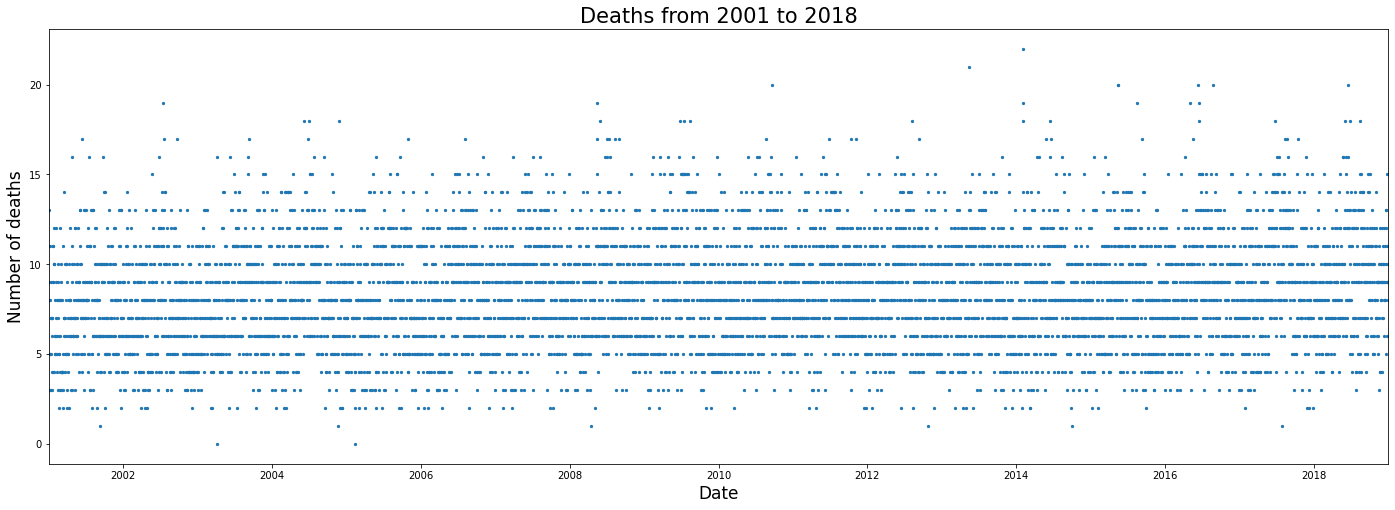

In [ ]:
# Plot
fig1 = plt.figure(figsize=(24, 8))
ax = fig1.add_subplot()
ax.scatter(df['DATE'], df['N_obitos'],color = 'C0',s=5)

# Set title and labels for axes
ax.set_title("Deaths from 2001 to 2018", fontsize = 21)
ax.set_xlabel("Date", fontsize = 17)
ax.set_ylabel("Number of deaths",fontsize = 17)
ax.set_xlim(pd.to_datetime(["2001-01-01", "2018-12-31"]))

date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)

plt.show()

## **Median for each month of the year**

Correlation was found between the median values for each month (median of the 18 years of the database for each month) of climatic parameters and number of hospitalizations.

In [ ]:
# Function to compute Pearson correlation
def get_correlation(df):
  variable = []
  pearson_c = []
  pearson_p = []
  type_c = []
  
  variables_list = ['TMIN','TMAX','T_RANGE','AVGPRESSURE','HMIN','HMAX','H_RANGE']
  titles = ['Minimum temperature (°C)','Maximum temperature (°C)','Thermal range (°C)','Average pressure (HPA)',
            'Minimum humidity (%)','Maximum humidity (%)','Humidity range (%)']

  for i in range(len(variables_list)):
    df_aux = df.dropna(0,subset = [f'{variables_list[i]}'])

    variable.append(titles[i])
    #pearson
    c,p = stats.pearsonr(df_aux[f'{variables_list[i]}'],df_aux['N_obitos'])
    pearson_c.append(round(c,2))
    pearson_p.append(round(p,4))
    
    if (p>0.05):
      type_c.append('-')
    else:
      if (np.abs(c)<0.3):
        type_c.append('negligible')
      elif (0.3<np.abs(c)<0.5):
        type_c.append('weak')
      elif (0.5<np.abs(c)<0.7):
        type_c.append('moderate')
      elif (0.7<np.abs(c)<0.9):
        type_c.append('strong')
      elif (np.abs(c)>0.9):
        type_c.append('very strong')

  table = pd.DataFrame()
  table['Climatic variable'] = titles
  table['Pearson coefficient'] = pearson_c
  table['P'] = pearson_p
  table['Correlation'] = type_c
  
  return table

In [ ]:
#create new column for month
df['Month'] = df['DATE'].dt.strftime('%m')

#create a new dataframe for median values
df2 = pd.DataFrame()

df2['Month']=df['Month']

list_columns = ['N_obitos','TMIN','TMAX','T_RANGE','AVGPRESSURE','HMIN','HMAX','H_RANGE']

for column in list_columns:
  df2[f'{column}'] = df.groupby('Month')[f'{column}'].transform('median')

df2 = df2.drop_duplicates('Month')

In [ ]:
get_correlation(df2)

,Climatic variable,Pearson coefficient,P,Correlation
0,Minimum temperature (°C),-0.93,0.0000,very strong
1,Maximum temperature (°C),-0.86,0.0003,strong
2,Thermal range (°C),0.71,0.0094,strong
3,Average pressure (HPA),0.90,0.0001,strong
4,Minimum humidity (%),-0.74,0.0062,strong
5,Maximum humidity (%),-0.60,0.0384,moderate
6,Humidity range (%),0.71,0.0091,strong


Plots of median of climatic parameters and number of deaths.

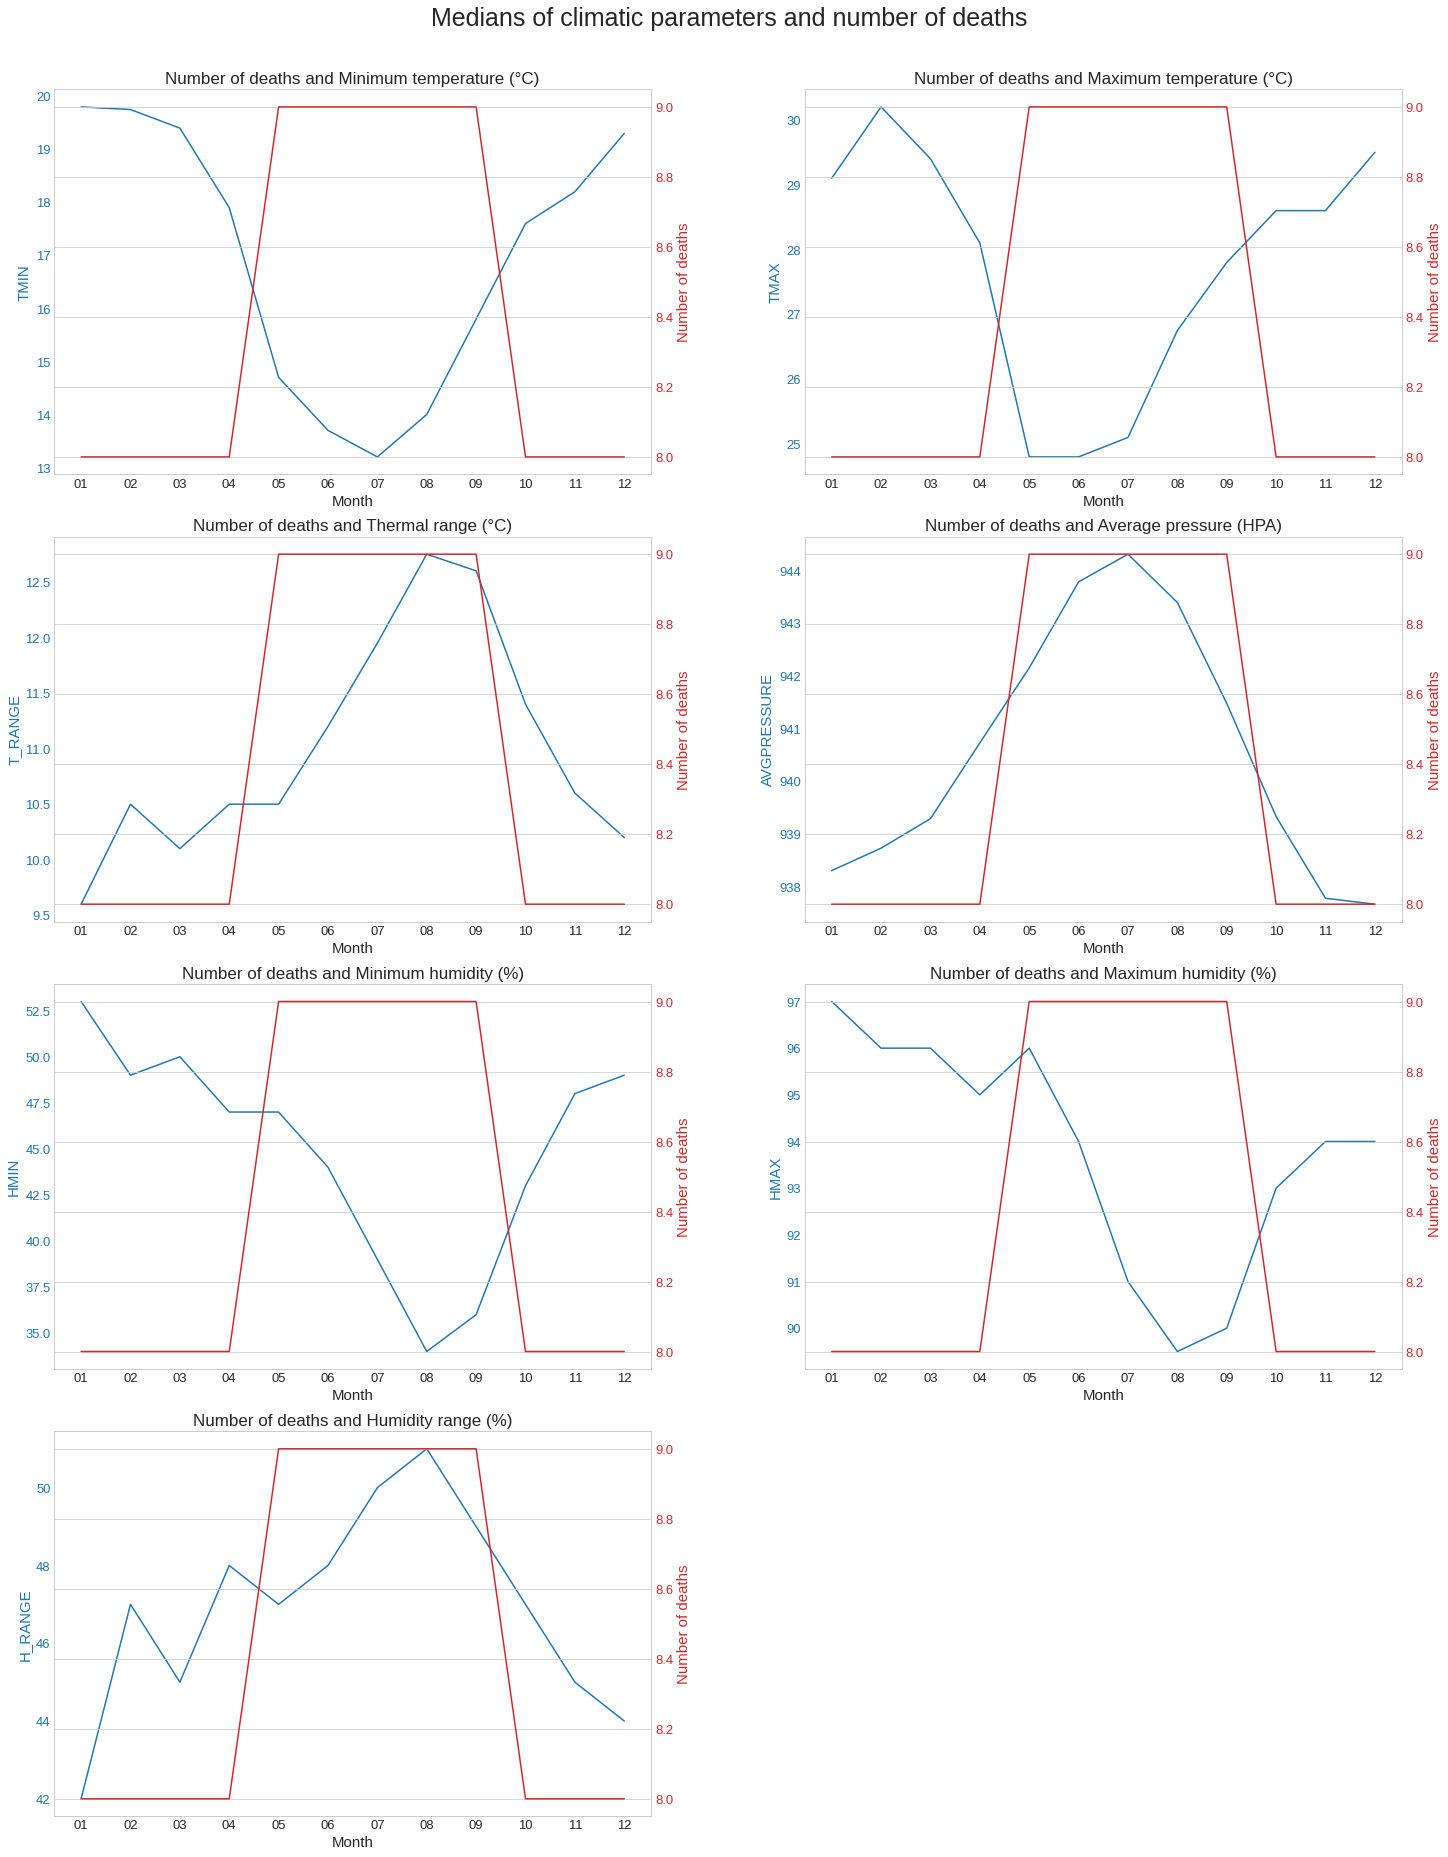

In [ ]:
fig1 = plt.figure(figsize=(21, 25))
plt.style.use('seaborn-whitegrid')
fig1.suptitle('Medians of climatic parameters and number of deaths',fontsize=25,y= 1.03)

variables_list = ['TMIN','TMAX','T_RANGE','AVGPRESSURE','HMIN','HMAX','H_RANGE']
titles = ['Minimum temperature (°C)','Maximum temperature (°C)','Thermal range (°C)','Average pressure (HPA)',
            'Minimum humidity (%)','Maximum humidity (%)','Humidity range (%)']

for i in range(0,len(variables_list)):
  fig1.subplots_adjust(hspace=3, wspace= 3)
  ax1 = fig1.add_subplot(4, 2, i+1)
  t = df2['Month']
  data1 = df2[f'{variables_list[i]}']
  data2 = df2['N_obitos']
  
  plt.style.use('seaborn-whitegrid')
  ax1.set_xlabel('Month',fontsize = 15)
  ax1.set_title(f'Number of deaths and {titles[i]}',fontsize = 17)
  ax1.set_ylabel(f'{variables_list[i]}', color='C0',fontsize = 15)
  ax1.plot(t, data1, color='C0')
  ax1.tick_params(axis='y', labelcolor='C0', labelsize=13)
  ax1.tick_params(axis='x', labelsize=13)

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  ax2.set_ylabel('Number of deaths', color='C3',fontsize = 15)  # we already handled the x-label with ax1
  ax2.plot(t, data2, color='C3')
  ax2.tick_params(axis='y', labelcolor='C3', labelsize = 13)
    
  ax1.grid() 

fig1.tight_layout()  # otherwise the right y-label is slightly clipped